In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from datetime import datetime
import shutil
import pickle
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Conv3D,MaxPooling2D
from keras import backend as K
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.applications import vgg16 as vgg
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import adam
from keras import optimizers
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Loss Curves
# plt.figure(figsize=[8,6])
# plt.plot(history.history['loss'],'r',linewidth=3.0)
# plt.plot(history.history['val_loss'],'b',linewidth=3.0)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Loss',fontsize=16)
# plt.title('Loss Curves',fontsize=16)
#   
# # Accuracy Curves
# plt.figure(figsize=[8,6])
# plt.plot(history.history['acc'],'r',linewidth=3.0)
# plt.plot(history.history['val_acc'],'b',linewidth=3.0)
# plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Accuracy',fontsize=16)
# plt.title('Accuracy Curves',fontsize=16)

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16011380071941213065
]


In [15]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [2]:
pristine_path = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/pristine/pristine_128/"
fake_path  = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/fake/fake_128/"

pristine_images = os.listdir(pristine_path)
fake_images = os.listdir(fake_path)

In [3]:
start = datetime.now()

pristine_list = []
pr_img = []
for file in pristine_images:
    try:   
        if file != '.DS_Store':
            img = Image.open(pristine_path+file)
    except FileNotFoundError:
        print("File not present")
        
    pristine_list.append(np.array(img))
    pr_img.append(img) 
    
pristine_array = np.array(pristine_list)   

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:07.867791


In [4]:
start = datetime.now()

fake_list = []
fk_img = []
for file in fake_images:
    try:
        if file != '.DS_Store':
            img = Image.open(fake_path+file)
    except FileNotFoundError:
        print("File not present")     
    fake_list.append(np.array(img))
    fk_img.append(img)

fake_array = np.array(fake_list)
    
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.241079


In [5]:
print(pristine_array.shape)
print(fake_array.shape)
print(pristine_array[0].shape)
print(fake_array[0].shape)
print(type(pristine_array))
print(type(fake_array))

(1048, 128, 128, 3)
(450, 128, 128, 3)
(128, 128, 3)
(128, 128, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
class_labels = [0]*1048+[1]*450

img_array = []
img_array = np.vstack((pristine_array,fake_array))

img_array.shape

(1498, 128, 128, 3)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_labels, test_size=0.25, stratify=class_labels,random_state=42)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1123, 128, 128, 3)
x_test shape: (375, 128, 128, 3)
1123 train samples
375 test samples


In [9]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
num_classes = 2

# input image dimensions
img_rows, img_cols = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [11]:
vgg16_model = vgg.VGG16(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])

In [13]:
vgg16_model.layers[0:4]

In [34]:
#for layer in vgg16_model.layers:
#    layer.trainable = False

In [40]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [13]:
for layer in vgg16_model.layers[7:]:
    layer.trainable = False

In [14]:
vgg16_model.layers[11:]

In [15]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [40]:
last_layer = vgg16_model.get_layer('block2_pool').output

In [41]:
last_layer

<tf.Tensor 'block2_pool_2/MaxPool:0' shape=(?, 32, 32, 128) dtype=float32>

In [24]:
model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu'))

top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

In [25]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 2097922   
Total params: 16,812,610
Trainable params: 2,358,082
Non-trainable params: 14,454,528
_________________________________________________________________
None
Train on 1123 samples, validate on 375 samples
Epoch 1/20
1123/1123 [==============================] - 793s 706ms/step - loss: 0.6447 - acc: 0.6794 - val_loss: 0.6246 - val_acc: 0.6933
Epoch 2/20
1123/1123 [==============================] - 792s 705ms/step - loss: 0.6097 - acc: 0.6990 - val_loss: 0.6099 - val_acc: 0.6773
Epoch 3/20
1123/1123 [==============================] - 751s 669ms/step - loss: 0.5893 - acc: 0.7044 - val_loss: 0.6011 - val_acc: 0.6933
Epoch 4/20
1123/1123 [==============================

Test loss: 0.5570678871472676
Test accuracy: 0.7306666650772095


NameError: name 'epochs' is not defined

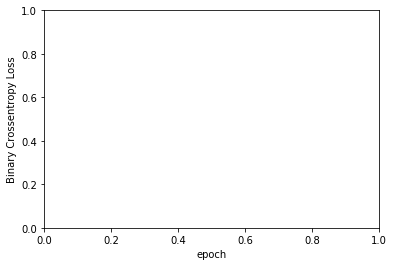

In [26]:
epochs = 20
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.5570678871472676
Test accuracy: 0.7306666650772095


In [12]:
for layer in vgg16_model.layers[7:]:
    layer.trainable = False

model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu',kernel_initializer='he_normal'))

top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

In [13]:
epochs = 25
batch_size = 64
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 2097922   
Total params: 16,812,610
Trainable params: 2,358,082
Non-trainable params: 14,454,528
_________________________________________________________________
None
Train on 1123 samples, validate on 375 samples
Epoch 1/25
1123/1123 [==============================] - 805s 716ms/step - loss: 0.6251 - acc: 0.6589 - val_loss: 0.6557 - val_acc: 0.6933
Epoch 2/25
1123/1123 [==============================] - 798s 711ms/step - loss: 0.6038 - acc: 0.6955 - val_loss: 0.6380 - val_acc: 0.6880
Epoch 3/25
1123/1123 [==============================] - 802s 714ms/step - loss: 0.5813 - acc: 0.6972 - val_loss: 0.6322 - val_acc: 0.6960
Epoch 4/25
1123/1123 [==============================

Test loss: 0.6218281364440919
Test accuracy: 0.6853333347638448


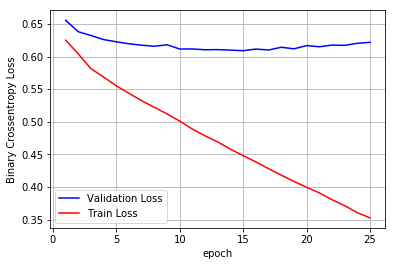

In [14]:

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [15]:
epochs = 30
batch_size = 64
model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu'))

top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 2097922   
Total params: 16,812,610
Trainable params: 2,358,082
Non-trainable params: 14,454,528
_________________________________________________________________
None
Train on 1123 samples, validate on 375 samples
Epoch 1/30
1123/1123 [==============================] - 807s 718ms/step - loss: 0.6568 - acc: 0.6589 - val_loss: 0.6352 - val_acc: 0.7013
Epoch 2/30
1123/1123 [==============================] - 807s 719ms/step - loss: 0.6115 - acc: 0.6919 - val_loss: 0.6187 - val_acc: 0.6987
Epoch 3/30
1123/1123 [==============================] - 815s 726ms/step - loss: 0.5918 - acc: 0.7017 - val_loss: 0.6104 - val_acc: 0.6960
Epoch 4/30
1123/1123 [==============================

Test loss: 0.6303467669487
Test accuracy: 0.6933333334922791


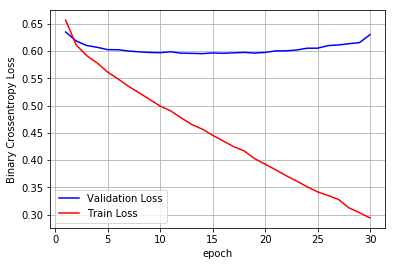

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [17]:
del model
del top_model

In [48]:
epochs = 30
model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

In [49]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6), metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_10 (Sequential)   (None, 2)                 4195842   
Total params: 18,910,530
Trainable params: 4,456,002
Non-trainable params: 14,454,528
_________________________________________________________________
None
Train on 1123 samples, validate on 375 samples
Epoch 1/30
1123/1123 [==============================] - 801s 713ms/step - loss: 0.8309 - acc: 0.3072 - val_loss: 0.7785 - val_acc: 0.3760
Epoch 2/30
1123/1123 [==============================] - 786s 700ms/step - loss: 0.7432 - acc: 0.3927 - val_loss: 0.7087 - val_acc: 0.4987
Epoch 3/30
1123/1123 [==============================] - 792s 705ms/step - loss: 0.6872 - acc: 0.5361 - val_loss: 0.6669 - val_acc: 0.6080
Epoch 4/30
1123/1123 [==============================

Test loss: 0.6148993074099223
Test accuracy: 0.6986666663487753


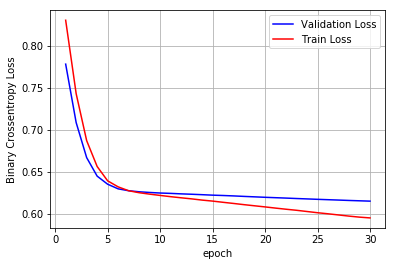

In [50]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_labels, test_size=0.20, stratify=class_labels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
num_classes = 2

# input image dimensions
img_rows, img_cols = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

x_train shape: (1198, 128, 128, 3)
x_test shape: (300, 128, 128, 3)
1198 train samples
300 test samples


In [20]:
vgg16_model = vgg.VGG16(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
vgg16_model.layers[0:7]


del model
del top_model

In [21]:
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 1048962   
Total params: 15,763,650
Trainable params: 15,763,650
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
epochs = 8
batch_size = 64

datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2)

# fits the model on batches with real-time data augmentation:
history=model.fit_generator(datagen.flow(x_train, y_train),
                    steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,validation_data=(x_test, y_test),
                           validation_steps=nb_validation_samples // batch_size)

Epoch 1/8
18/18 [==============================] - 540s 30s/step - loss: 0.6102 - acc: 0.7170 - val_loss: 0.5995 - val_acc: 0.6967
Epoch 2/8
18/18 [==============================] - 512s 28s/step - loss: 0.6232 - acc: 0.6858 - val_loss: 0.5959 - val_acc: 0.6967
Epoch 3/8
18/18 [==============================] - 508s 28s/step - loss: 0.5781 - acc: 0.6876 - val_loss: 0.5903 - val_acc: 0.7000
Epoch 4/8
18/18 [==============================] - 544s 30s/step - loss: 0.5504 - acc: 0.7188 - val_loss: 0.5859 - val_acc: 0.6967
Epoch 5/8
18/18 [==============================] - 531s 30s/step - loss: 0.4828 - acc: 0.7735 - val_loss: 0.5743 - val_acc: 0.6867
Epoch 6/8
18/18 [==============================] - 605s 34s/step - loss: 0.5171 - acc: 0.7257 - val_loss: 0.5977 - val_acc: 0.6733
Epoch 7/8
18/18 [==============================] - 558s 31s/step - loss: 0.4640 - acc: 0.7884 - val_loss: 0.6167 - val_acc: 0.6900
Epoch 8/8
18/18 [==============================] - 547s 30s/step - loss: 0.4426 - a

In [23]:
epochs = 8
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Train on 1198 samples, validate on 300 samples
Epoch 1/8
1198/1198 [==============================] - 1041s 869ms/step - loss: 0.3295 - acc: 0.8689 - val_loss: 0.6307 - val_acc: 0.7000
Epoch 2/8
1198/1198 [==============================] - 1032s 861ms/step - loss: 0.2405 - acc: 0.9240 - val_loss: 0.6827 - val_acc: 0.6900
Epoch 3/8
1198/1198 [==============================] - 1043s 871ms/step - loss: 0.1633 - acc: 0.9533 - val_loss: 0.7310 - val_acc: 0.6933
Epoch 4/8
1198/1198 [==============================] - 1045s 873ms/step - loss: 0.1050 - acc: 0.9808 - val_loss: 0.8488 - val_acc: 0.7233
Epoch 5/8
1198/1198 [==============================] - 1027s 857ms/step - loss: 0.0860 - acc: 0.9800 - val_loss: 0.9912 - val_acc: 0.7000
Epoch 6/8
1198/1198 [==============================] - 1027s 857ms/step - loss: 0.0731 - acc: 0.9825 - val_loss: 0.9016 - val_acc: 0.6933
Epoch 7/8
1198/1198 [==============================] - 1029s 859ms/step - loss: 0.0619 - acc: 0.9875 - val_loss: 0.9784 - val

Test loss: 0.9983818833033243
Test accuracy: 0.7033333325386047


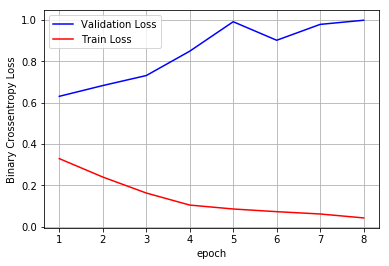

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [25]:
vgg16_model = vgg.VGG16(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
vgg16_model.layers[0:7]


del model
del top_model

In [26]:
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(vgg16_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_8 (Sequential)    (None, 2)                 1048962   
Total params: 15,763,650
Trainable params: 15,763,650
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
epochs = 25
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Train on 1198 samples, validate on 300 samples
Epoch 1/25
1198/1198 [==============================] - 1030s 860ms/step - loss: 0.6353 - acc: 0.6828 - val_loss: 0.6058 - val_acc: 0.6933
Epoch 2/25
1198/1198 [==============================] - 1029s 859ms/step - loss: 0.5479 - acc: 0.7112 - val_loss: 0.6012 - val_acc: 0.6967
Epoch 3/25
1198/1198 [==============================] - 1031s 860ms/step - loss: 0.4750 - acc: 0.7604 - val_loss: 0.6134 - val_acc: 0.6667
Epoch 4/25
1198/1198 [==============================] - 1030s 860ms/step - loss: 0.3965 - acc: 0.8322 - val_loss: 0.6196 - val_acc: 0.6900
Epoch 5/25
1198/1198 [==============================] - 1030s 860ms/step - loss: 0.3140 - acc: 0.8823 - val_loss: 0.6786 - val_acc: 0.6600
Epoch 6/25
1198/1198 [==============================] - 1030s 859ms/step - loss: 0.2266 - acc: 0.9332 - val_loss: 0.7583 - val_acc: 0.6867
Epoch 7/25
1198/1198 [==============================] - 1030s 860ms/step - loss: 0.1578 - acc: 0.9541 - val_loss: 0.868

Test loss: 1.3160930077234905
Test accuracy: 0.6533333341280619


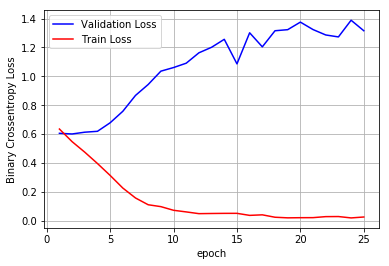

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_labels, test_size=0.20, stratify=class_labels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
num_classes = 2

# input image dimensions
img_rows, img_cols = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    

x_train shape: (1198, 128, 128, 3)
x_test shape: (300, 128, 128, 3)
1198 train samples
300 test samples


In [10]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])

94658560/94653016 [==============================] - 42s 0us/step


In [14]:
del model
del top_model

In [11]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(resnet_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 8389378   
Total params: 31,977,090
Trainable params: 31,923,970
Non-trainable params: 53,120
_________________________________________________________________
None


In [16]:
epochs = 5
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Train on 1198 samples, validate on 300 samples
Epoch 1/5
1198/1198 [==============================] - 1258s 1s/step - loss: 1.0217 - acc: 0.6194 - val_loss: 0.9310 - val_acc: 0.6433
Epoch 2/5
1198/1198 [==============================] - 1179s 984ms/step - loss: 0.2930 - acc: 0.8815 - val_loss: 0.9000 - val_acc: 0.6400
Epoch 3/5
1198/1198 [==============================] - 1378s 1s/step - loss: 0.1155 - acc: 0.9800 - val_loss: 0.9100 - val_acc: 0.6633
Epoch 4/5
1198/1198 [==============================] - 1360s 1s/step - loss: 0.0739 - acc: 0.9900 - val_loss: 0.9410 - val_acc: 0.6733
Epoch 5/5
1198/1198 [==============================] - 1167s 974ms/step - loss: 0.0477 - acc: 0.9983 - val_loss: 0.9485 - val_acc: 0.6600


Test loss: 0.9485485943158468
Test accuracy: 0.6600000007947286


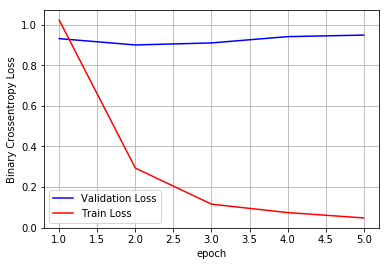

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [10]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])

In [11]:
resnet_model.layers[:5]

In [22]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
del model
del top_model
for layer in resnet_model.layers[14:]:
    layer.trainable = False

In [23]:
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(resnet_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 8389378   
Total params: 31,977,090
Trainable params: 8,456,962
Non-trainable params: 23,520,128
_________________________________________________________________
None


In [24]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Train on 1198 samples, validate on 300 samples
Epoch 1/30
1198/1198 [==============================] - 1131s 944ms/step - loss: 1.0604 - acc: 0.5835 - val_loss: 1.1431 - val_acc: 0.6067
Epoch 2/30
1198/1198 [==============================] - 1051s 877ms/step - loss: 0.6068 - acc: 0.7429 - val_loss: 1.0886 - val_acc: 0.6233
Epoch 3/30
1198/1198 [==============================] - 1050s 877ms/step - loss: 0.3985 - acc: 0.8139 - val_loss: 1.0911 - val_acc: 0.6300
Epoch 4/30
1198/1198 [==============================] - 1052s 878ms/step - loss: 0.2731 - acc: 0.8873 - val_loss: 1.0742 - val_acc: 0.6433
Epoch 5/30
1198/1198 [==============================] - 1045s 872ms/step - loss: 0.2101 - acc: 0.9274 - val_loss: 1.0644 - val_acc: 0.6600
Epoch 6/30
1198/1198 [==============================] - 1020s 852ms/step - loss: 0.1569 - acc: 0.9608 - val_loss: 1.0825 - val_acc: 0.6500
Epoch 7/30
1198/1198 [==============================] - 1022s 853ms/step - loss: 0.1304 - acc: 0.9750 - val_loss: 1.089

Test loss: 1.2657503199577331
Test accuracy: 0.6666666666666666


ValueError: x and y must have same first dimension, but have shapes (5,) and (30,)

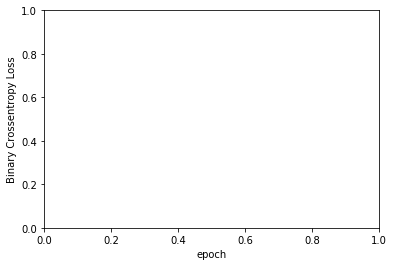

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_labels, test_size=0.25, stratify=class_labels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
num_classes = 2

# input image dimensions
img_rows, img_cols = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    

x_train shape: (1123, 128, 128, 3)
x_test shape: (375, 128, 128, 3)
1123 train samples
375 test samples


In [8]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
#del model
#del top_model
for layer in resnet_model.layers[:]:
    layer.trainable = False

    
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(resnet_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['accuracy'])
print(model.summary())

epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, batch_size=128, validation_data=(x_test, y_test), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 2097346   
Total params: 25,685,058
Trainable params: 2,097,346
Non-trainable params: 23,587,712
_________________________________________________________________
None
Train on 1123 samples, validate on 375 samples
Epoch 1/30
1123/1123 [==============================] - 659s 587ms/step - loss: 0.9253 - acc: 0.6251 - val_loss: 0.6201 - val_acc: 0.6987
Epoch 2/30
1123/1123 [==============================] - 786s 700ms/step - loss: 0.3625 - acc: 0.8477 - val_loss: 0.6353 - val_acc: 0.6987
Epoch 3/30
1123/1123 [==============================] - 788s 702ms/step - loss: 0.1937 - acc: 0.9466 - val_loss: 0.6941 - val_acc: 0.6987
Epoch 4/30
1123/1123 [==============================

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0644841674168906
Test accuracy: 0.6986666674613953


In [10]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
del model
del top_model
for layer in resnet_model.layers[:]:
    layer.trainable = False

    
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(resnet_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 2228418   
Total params: 25,816,130
Trainable params: 2,162,882
Non-trainable params: 23,653,248
_________________________________________________________________
None


In [11]:
epochs = 8
batch_size = 64

datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# fits the model on batches with real-time data augmentation:
history=model.fit_generator(datagen.flow(x_train, y_train),
                    steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,validation_data=(x_test, y_test),
                           validation_steps=nb_validation_samples // batch_size)

Epoch 1/8
17/17 [==============================] - 195s 11s/step - loss: 0.9043 - acc: 0.6471 - val_loss: 0.6109 - val_acc: 0.6987
Epoch 2/8
17/17 [==============================] - 189s 11s/step - loss: 0.8809 - acc: 0.6618 - val_loss: 0.6109 - val_acc: 0.6987
Epoch 3/8
17/17 [==============================] - 185s 11s/step - loss: 0.8868 - acc: 0.6587 - val_loss: 0.6120 - val_acc: 0.6987
Epoch 4/8
17/17 [==============================] - 187s 11s/step - loss: 0.9062 - acc: 0.6360 - val_loss: 0.6175 - val_acc: 0.6987
Epoch 5/8
17/17 [==============================] - 181s 11s/step - loss: 0.9018 - acc: 0.6607 - val_loss: 0.6252 - val_acc: 0.6987
Epoch 6/8
17/17 [==============================] - 191s 11s/step - loss: 0.7858 - acc: 0.6783 - val_loss: 0.6409 - val_acc: 0.6987
Epoch 7/8
17/17 [==============================] - 193s 11s/step - loss: 0.8321 - acc: 0.6476 - val_loss: 0.6540 - val_acc: 0.6987
Epoch 8/8
17/17 [==============================] - 189s 11s/step - loss: 0.8266 - a

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.666226343313853
Test accuracy: 0.6986666650772094


In [17]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=x_train.shape[1:])
del model
del top_model
for layer in resnet_model.layers[:]:
    layer.trainable = False

    
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(resnet_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(4, 4, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dropout(0.5))
top_model.add(Denout(0.2))
top_model.add(Densse(64, activation='relu'))
top_model.add(Drope(64, activation='relu',kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6), metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 2101762   
Total params: 25,689,474
Trainable params: 2,101,634
Non-trainable params: 23,587,840
_________________________________________________________________
None


In [18]:
epochs = 35
batch_size = 64

datagen = ImageDataGenerator(
        shear_range=0.28,
        zoom_range=0.25,
        horizontal_flip=True)

# fits the model on batches with real-time data augmentation:
history=model.fit_generator(datagen.flow(x_train, y_train),
                    steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,validation_data=(x_test, y_test),
                           validation_steps=nb_validation_samples // batch_size)

Epoch 1/35
17/17 [==============================] - 192s 11s/step - loss: 0.9006 - acc: 0.5735 - val_loss: 0.6374 - val_acc: 0.6987
Epoch 2/35
17/17 [==============================] - 189s 11s/step - loss: 0.9582 - acc: 0.5276 - val_loss: 0.6389 - val_acc: 0.6987
Epoch 3/35
17/17 [==============================] - 183s 11s/step - loss: 0.9710 - acc: 0.5257 - val_loss: 0.6350 - val_acc: 0.6987
Epoch 4/35
17/17 [==============================] - 189s 11s/step - loss: 0.9823 - acc: 0.5386 - val_loss: 0.6312 - val_acc: 0.6987
Epoch 5/35
17/17 [==============================] - 183s 11s/step - loss: 0.9168 - acc: 0.5220 - val_loss: 0.6310 - val_acc: 0.6987
Epoch 6/35
17/17 [==============================] - 189s 11s/step - loss: 0.9641 - acc: 0.5441 - val_loss: 0.6292 - val_acc: 0.6987
Epoch 7/35
17/17 [==============================] - 186s 11s/step - loss: 0.9380 - acc: 0.5018 - val_loss: 0.6283 - val_acc: 0.6987
Epoch 8/35
17/17 [==============================] - 189s 11s/step - loss: 0.

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6237001342773437
Test accuracy: 0.6986666661898295


In [7]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_labels, test_size=0.25, stratify=class_labels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
num_classes = 2

# input image dimensions
img_rows, img_cols = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    

x_train shape: (1123, 128, 128, 3)
x_test shape: (375, 128, 128, 3)
1123 train samples
375 test samples


In [8]:
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

87916544/87910968 [==============================] - 85s 1us/step


In [9]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
inception_model.layers[:5]

In [11]:
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
#del model
#del top_model
for layer in inception_model.layers[8:]:
    layer.trainable = False

    
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(inception_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dropout(0.5))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(64, activation='relu',kernel_initializer='he_normal'))
top_model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6), metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 528642    
Total params: 22,331,426
Trainable params: 557,218
Non-trainable params: 21,774,208
_________________________________________________________________
None


In [12]:
epochs = 6
batch_size = 64

datagen = ImageDataGenerator(
        shear_range=0.28,
        zoom_range=0.25,
        horizontal_flip=True)

# fits the model on batches with real-time data augmentation:
history=model.fit_generator(datagen.flow(x_train, y_train),
                    steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,validation_data=(x_test, y_test),
                           validation_steps=nb_validation_samples // batch_size)

Epoch 1/6
17/17 [==============================] - 234s 14s/step - loss: 0.8611 - acc: 0.6581 - val_loss: 1.2986 - val_acc: 0.6960
Epoch 2/6
17/17 [==============================] - 219s 13s/step - loss: 0.7803 - acc: 0.6820 - val_loss: 1.2636 - val_acc: 0.6987
Epoch 3/6
17/17 [==============================] - 210s 12s/step - loss: 0.8298 - acc: 0.6456 - val_loss: 1.2252 - val_acc: 0.7013
Epoch 4/6
17/17 [==============================] - 220s 13s/step - loss: 0.8608 - acc: 0.6452 - val_loss: 1.1902 - val_acc: 0.6933
Epoch 5/6
17/17 [==============================] - 209s 12s/step - loss: 0.8434 - acc: 0.6402 - val_loss: 1.1539 - val_acc: 0.6933
Epoch 6/6
17/17 [==============================] - 218s 13s/step - loss: 0.7570 - acc: 0.7004 - val_loss: 1.1258 - val_acc: 0.6960


In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1257634963989258
Test accuracy: 0.6960000001589457


In [17]:
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
del model
del top_model
for layer in inception_model.layers[5:]:
    layer.trainable = False

    
#for layer in vgg16_model.layers[7:]:
#    layer.trainable = False
    
model=Sequential()
model.add(inception_model)


top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))
#model_aug.add(Dropout(0.3))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model.add(top_model)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6), metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 2097922   
Total params: 23,900,706
Trainable params: 2,108,034
Non-trainable params: 21,792,672
_________________________________________________________________
None


In [18]:
epochs = 20
batch_size = 64

datagen = ImageDataGenerator(
        shear_range=0.28,
        zoom_range=0.25,
        horizontal_flip=True)

# fits the model on batches with real-time data augmentation:
history=model.fit_generator(datagen.flow(x_train, y_train),
                    steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,validation_data=(x_test, y_test),
                           validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
17/17 [==============================] - 262s 15s/step - loss: 0.8564 - acc: 0.5790 - val_loss: 1.0196 - val_acc: 0.6053
Epoch 2/20
17/17 [==============================] - 239s 14s/step - loss: 0.7970 - acc: 0.6011 - val_loss: 1.0371 - val_acc: 0.6240
Epoch 3/20
17/17 [==============================] - 259s 15s/step - loss: 0.8293 - acc: 0.5663 - val_loss: 1.0487 - val_acc: 0.6240
Epoch 4/20
17/17 [==============================] - 272s 16s/step - loss: 0.8201 - acc: 0.5754 - val_loss: 1.0680 - val_acc: 0.6320
Epoch 5/20
17/17 [==============================] - 257s 15s/step - loss: 0.9253 - acc: 0.5514 - val_loss: 1.0868 - val_acc: 0.6427
Epoch 6/20
17/17 [==============================] - 269s 16s/step - loss: 0.8074 - acc: 0.5901 - val_loss: 1.0912 - val_acc: 0.6533
Epoch 7/20
17/17 [==============================] - 258s 15s/step - loss: 0.8792 - acc: 0.5774 - val_loss: 1.0823 - val_acc: 0.6453
Epoch 8/20
17/17 [==============================] - 270s 16s/step - loss: 0.

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1312928546269734
Test accuracy: 0.6640000014305115


Test loss: 1.1312928546269734
Test accuracy: 0.6640000014305115


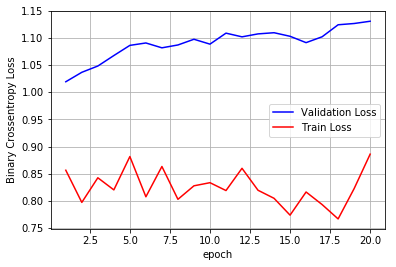

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)